In [1]:
import torch
import numpy as np
from pathlib import Path
import argparse
from neuralop.models import UNO
from magplot.base import create_mesh, mag_plotter
import pyvista as pv
pv.start_xvfb()
pv.set_jupyter_backend('static')

import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from rtmag.test.analytical_field import get_analytic_b_field
from skimage.transform import resize

from rtmag.test.eval_plot import plot_sample

from rtmag.test.eval import evaluate

In [2]:
b_cube = get_analytic_b_field(n=1, m=1, l=0.3, psi=np.pi / 4, resolution=[256, 256, 256]).astype(np.float32)

In [3]:
b_cube.shape

(256, 256, 256, 3)

In [4]:
b_bottom = b_cube[:, :, 0, :]
b_bottom.shape

(256, 256, 3)

(512, 256, 3)


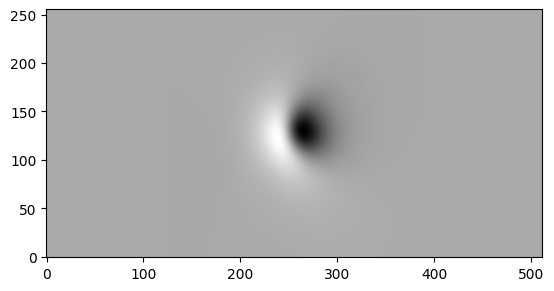

In [5]:
b_bottom_padding = np.pad(b_bottom, pad_width=[(128, 128), (0, 0), (0, 0)], mode='constant', constant_values=0)
print(b_bottom_padding.shape)
plt.imshow(b_bottom_padding[:, :, 2].T, origin='lower', cmap='gray')

In [6]:
b_bottom_padding[128:-128, :, :].shape

(256, 256, 3)

In [7]:
np.allclose(b_bottom_padding[128:-128, :, :], b_bottom)

True

In [8]:
meta_path = Path("/home/usr/workspace/base/uno_pi_cc_hnorm_1_unit_aug_ccc_square")
checkpoint = torch.load(meta_path / "best_model.pt", map_location=device)

args = argparse.Namespace()
info = np.load(meta_path / 'args.npy', allow_pickle=True).item()
for key, value in info.items():
        args.__dict__[key] = value

# b_norm = args.data["b_norm"]

model = UNO(
        hidden_channels = args.model["hidden_channels"],
        in_channels = args.model["in_channels"],
        out_channels = args.model["out_channels"],
        lifting_channels = args.model["lifting_channels"],
        projection_channels = args.model["projection_channels"],
        n_layers = args.model["n_layers"],

        factorization = args.model["factorization"],
        implementation = args.model["implementation"],
        rank = args.model["rank"],

        uno_n_modes = args.model["uno_n_modes"], 
        uno_out_channels = args.model["uno_out_channels"],
        uno_scalings = args.model["uno_scalings"],
    ).to(device)

checkpoint = torch.load(meta_path / 'best_model.pt')

model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [9]:
model_input = b_bottom_padding
model_input = model_input[None, :, :, None, :]
b_norm = np.max(np.abs(model_input))
print(b_norm)
model_input = model_input.transpose(0, 3, 2, 1, 4) / b_norm
model_input = torch.from_numpy(model_input).to(device) 
model_input.shape

293.01736


torch.Size([1, 1, 256, 512, 3])

In [10]:
model_output = model(model_input)

In [11]:
model_output.shape

torch.Size([1, 256, 256, 512, 3])

In [12]:
bb = model_output.detach().cpu().numpy().transpose(0, 3, 2, 1, 4)[0]
divi = (b_norm / np.arange(1, bb.shape[2] + 1)).reshape(1, 1, -1, 1)
bb = bb * divi

In [13]:
bb.shape

(512, 256, 256, 3)

In [14]:
b = bb[128:-128, :, :, :]

In [15]:
b.shape

(256, 256, 256, 3)

In [16]:
evaluate(b, b_cube)

C_vec     : 0.9487
C_cs      : 0.6299
E_n'      : 0.5214
E_m'      : 0.2908
eps       : 0.8230
CW_sin    : 0.7050
L_f       : 0.2613
L_d       : 0.2054
l2_err    : 0.3199


{'C_vec': 0.9486773976044528,
 'C_cs': 0.6299208989279079,
 "E_n'": 0.5214008708299944,
 "E_m'": 0.290782732042409,
 'eps': 0.8230464252175541,
 'CW_sin': 0.7049777610305761,
 'L_f': 0.2612613785686201,
 'L_d': 0.20543613264870958,
 'l2_err': 0.31994282726513773}

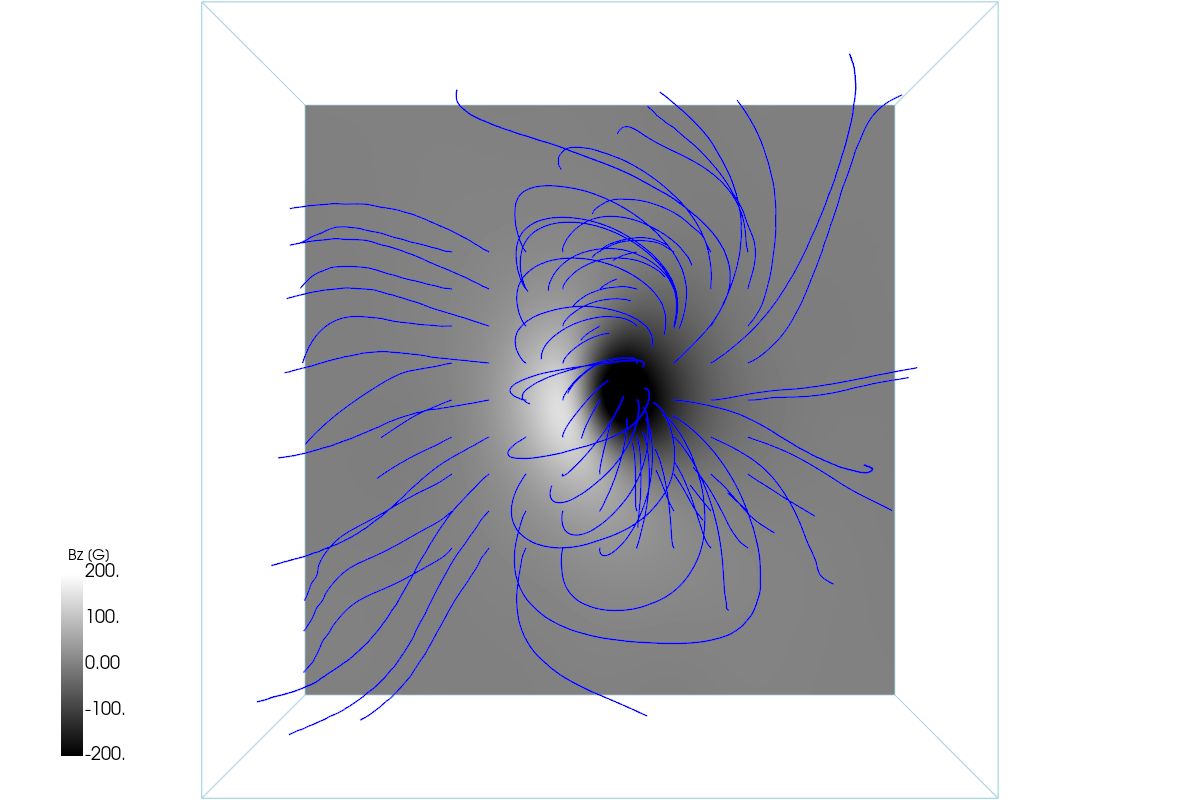

In [17]:
vmin = -200
vmax = 200
i_siz=b.shape[0] / 2
j_siz=b.shape[1] / 2
i_res=8
j_res=8
window_size=(1200, 800)
zoom=1.5
max_time=10000
camera_position = 'xy'
b_title = ''
title_fontsize = 10

bx = b[..., 0]
by = b[..., 1]
bz = b[..., 2]
mesh = create_mesh(bx, by, bz)
b_plot = mag_plotter(mesh)
b_tube, b_bottom, b_dargs = b_plot.create_mesh(i_siz=i_siz, j_siz=j_siz, i_resolution=i_res, j_resolution=j_res, vmin=vmin, vmax=vmax, max_time=max_time)


p = pv.Plotter(off_screen=False, window_size=window_size)
p.add_mesh(b_plot.grid.outline())
p.add_mesh(b_bottom, cmap='gray', **b_dargs)
p.add_mesh(b_tube, lighting=False, color='blue')
p.camera_position = camera_position
p.add_title(b_title, font_size=title_fontsize)
p.camera.zoom(zoom)
p.show()

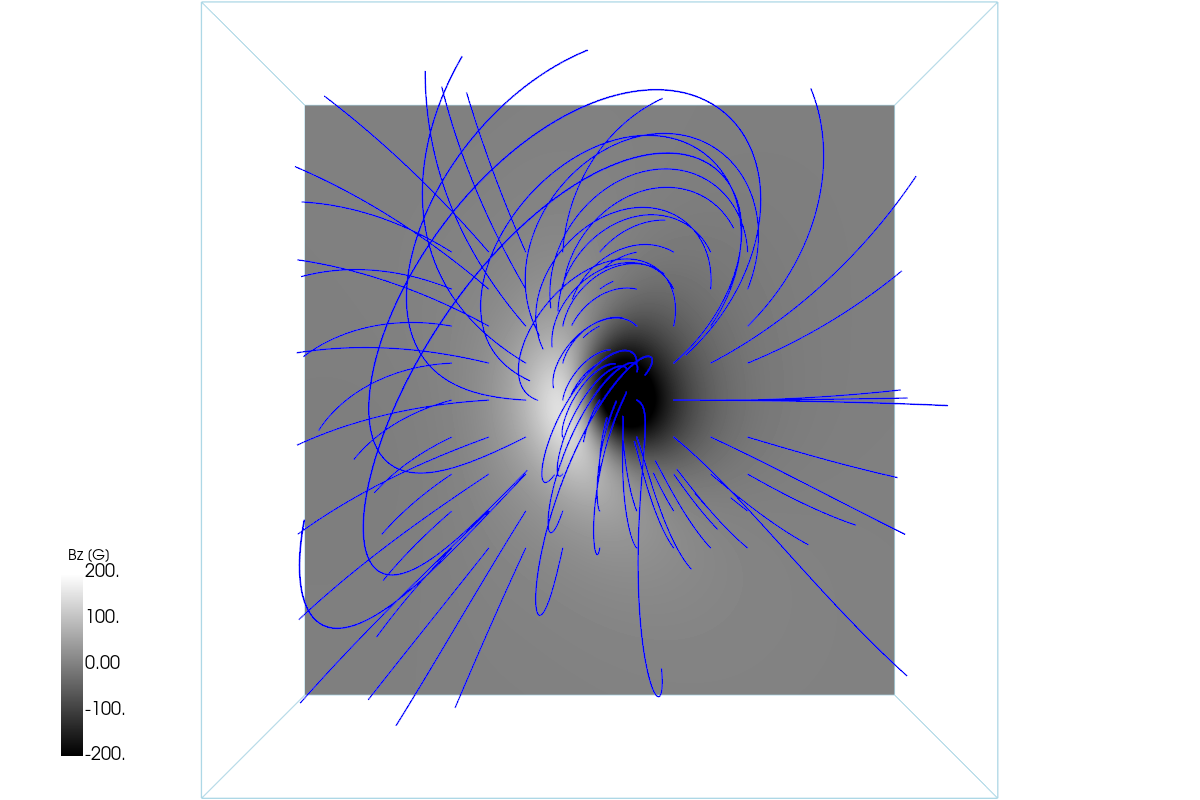

In [18]:
vmin = -200
vmax = 200
i_siz=b_cube.shape[0] / 2
j_siz=b_cube.shape[1] / 2
i_res=8
j_res=8
window_size=(1200, 800)
zoom=1.5
max_time=10000
camera_position = 'xy'
b_title = ''
title_fontsize = 10

bx = b_cube[..., 0]
by = b_cube[..., 1]
bz = b_cube[..., 2]
mesh = create_mesh(bx, by, bz)
b_plot = mag_plotter(mesh)
b_tube, b_bottom, b_dargs = b_plot.create_mesh(i_siz=i_siz, j_siz=j_siz, i_resolution=i_res, j_resolution=j_res, vmin=vmin, vmax=vmax, max_time=max_time)


p = pv.Plotter(off_screen=False, window_size=window_size)
p.add_mesh(b_plot.grid.outline())
p.add_mesh(b_bottom, cmap='gray', **b_dargs)
p.add_mesh(b_tube, lighting=False, color='blue')
p.camera_position = camera_position
p.add_title(b_title, font_size=title_fontsize)
p.camera.zoom(zoom)
p.show()

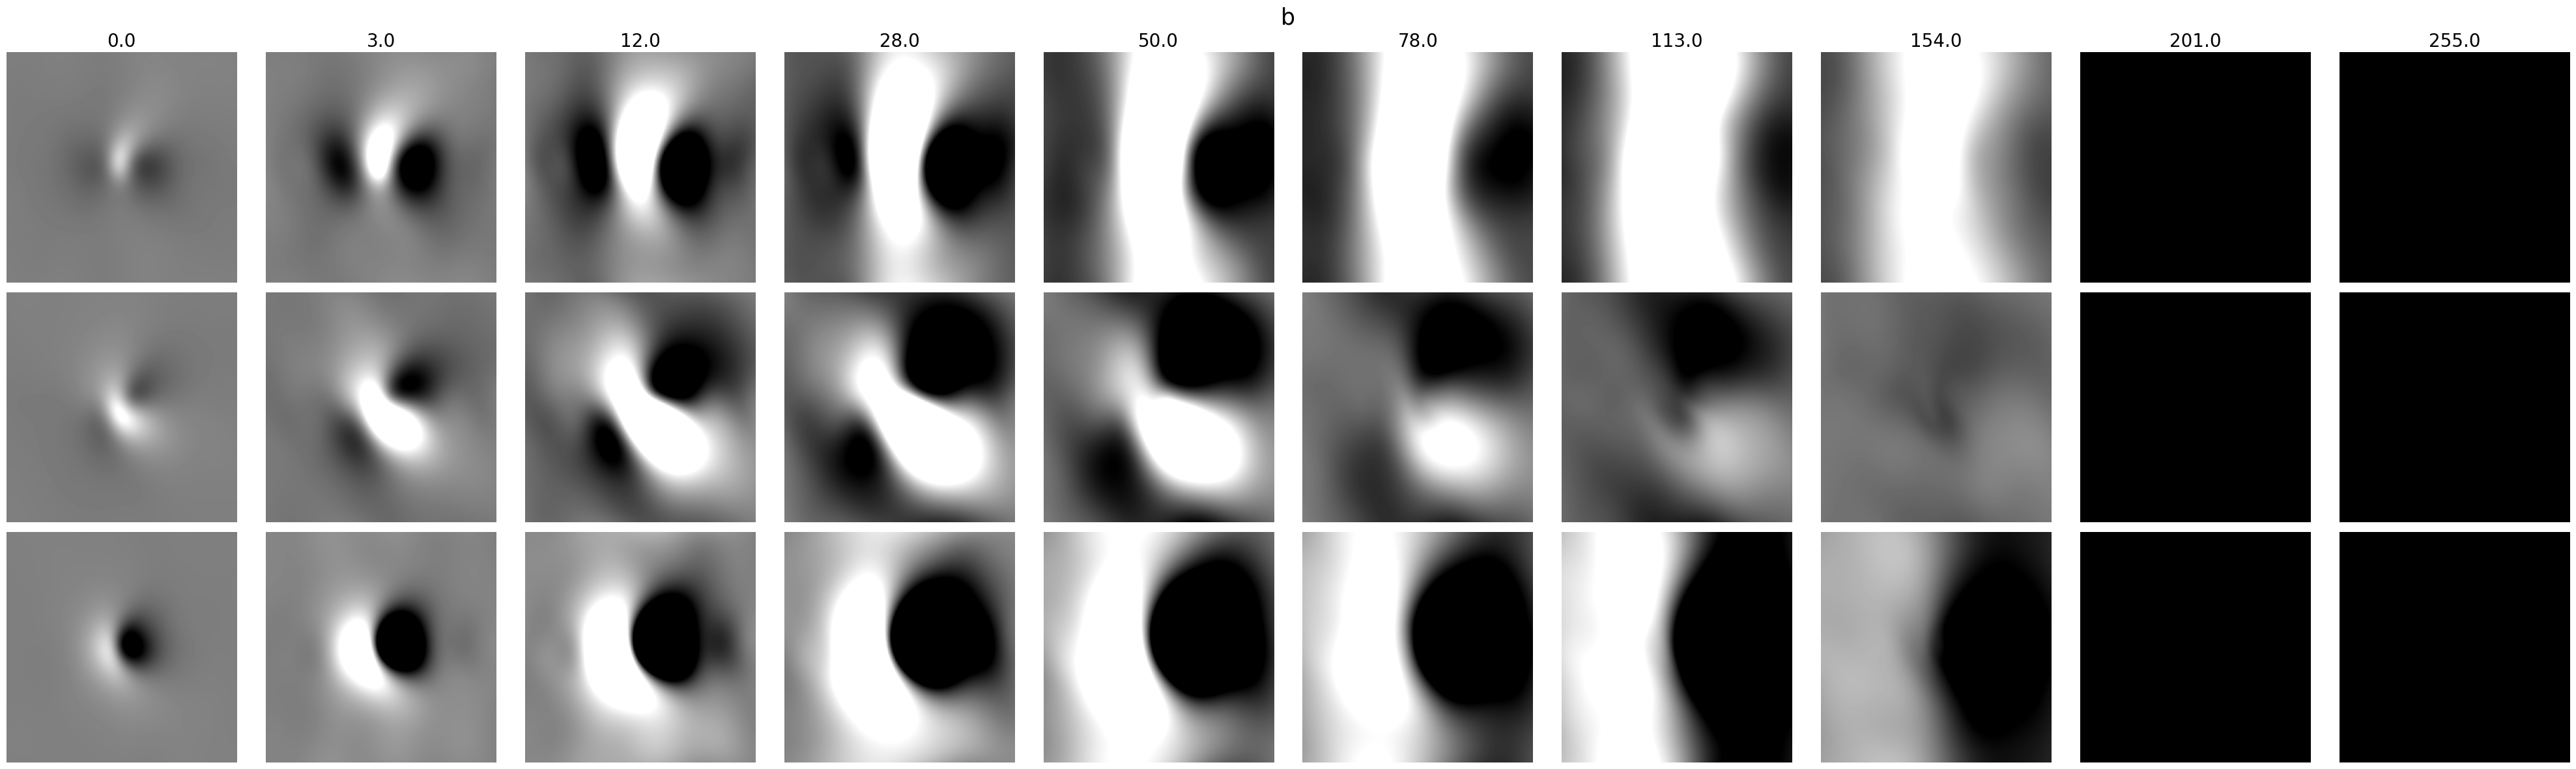

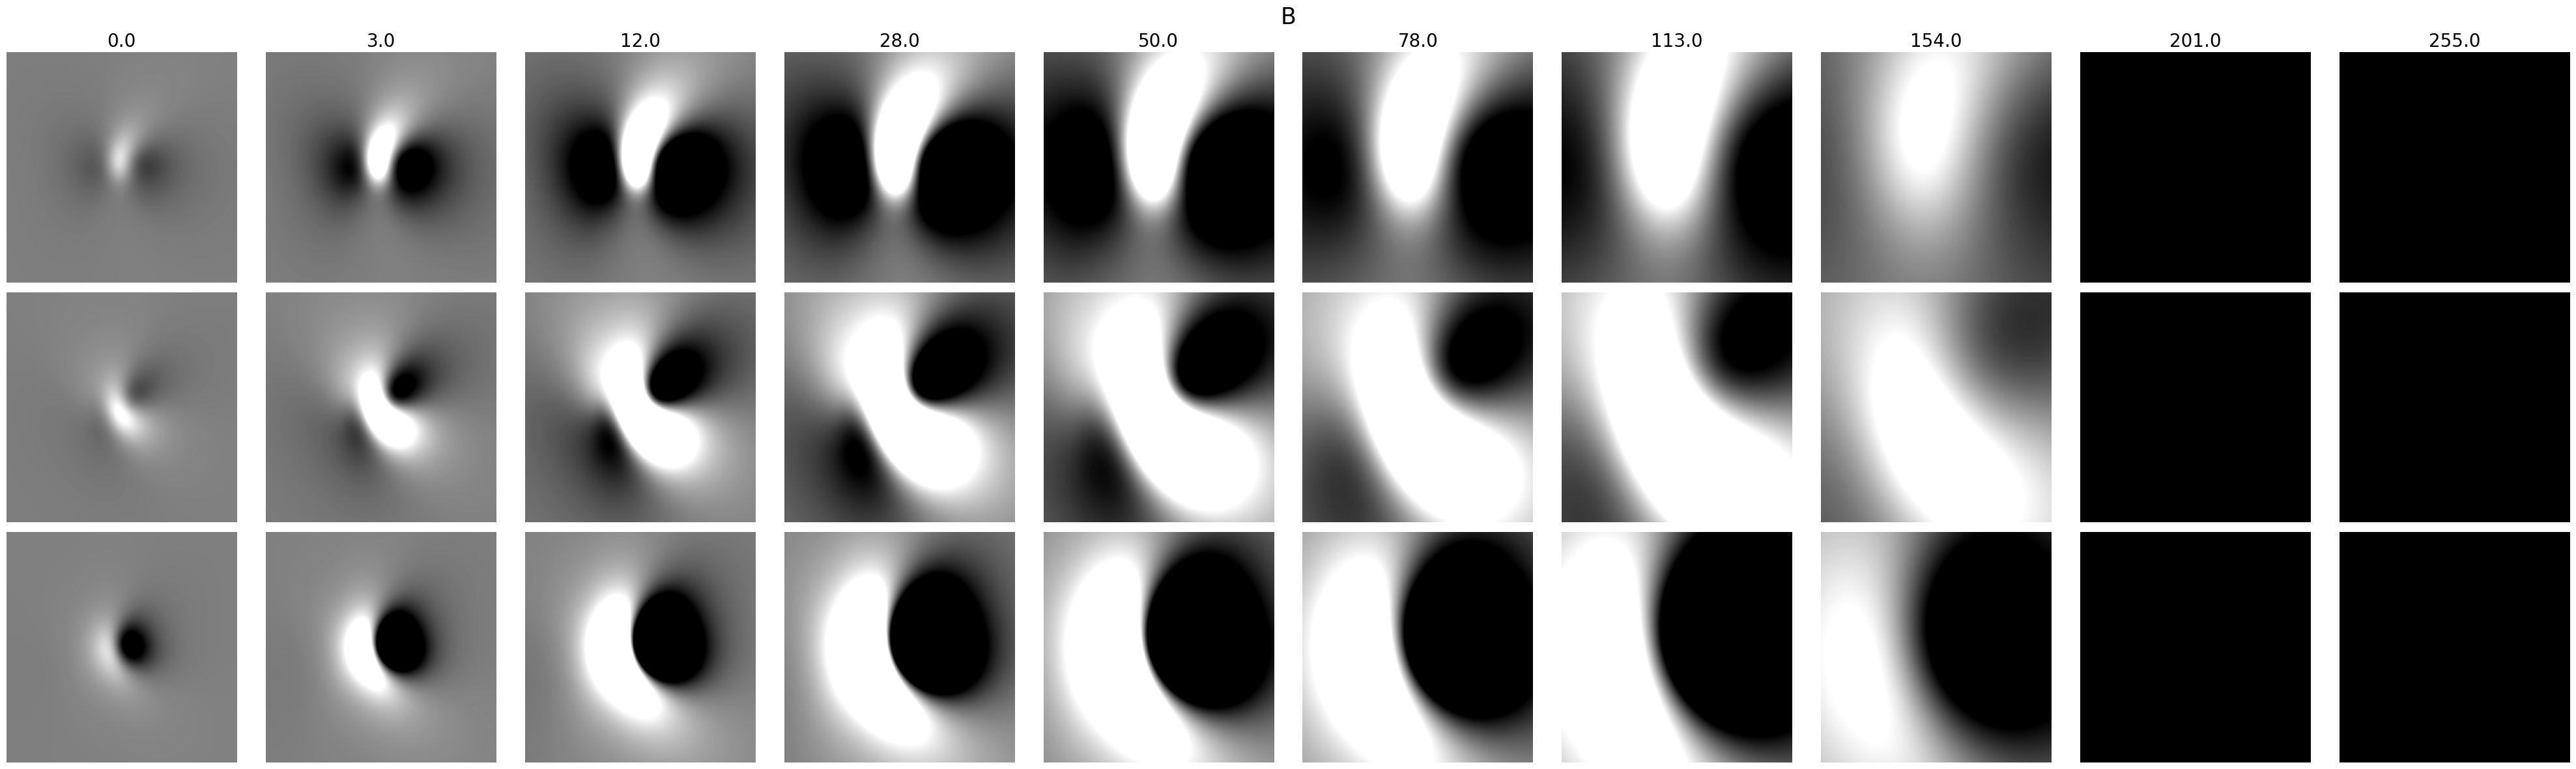

In [19]:
plot_sample(b, b_cube, v_mm=200)